# **Section C: Customer Sentiment Analysis (Hospitality Reviews)**

## **Objective**

This section analyses customer sentiment from hotel reviews using:

- Text preprocessing and NLP techniques
- VADER sentiment analysis
- Artificial Neural Network (ANN) for review rating prediction

The objective is to extract actionable insights to improve customer satisfaction and service quality.


### **1. Core Libraries**

In [ ]:
# Data handling
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Feature extraction & ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### **2. Dataset Overview**

In [ ]:
# Load dataset
df = pd.read_excel("Reviews.xlsx")

# Select relevant columns
df = df[['reviews.text', 'reviews.rating']]

# Remove missing values
df.dropna(inplace=True)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (9999, 2)


,reviews.text,reviews.rating
0,Our experience at Rancho Valencia was absolute...,5.0
1,Amazing place. Everyone was extremely warm and...,5.0
2,We booked a 3 night stay at Rancho Valencia to...,5.0
3,Currently in bed writing this for the past hr ...,2.0
4,I live in Md and the Aloft is my Home away fro...,5.0


### **3. Text Preprocessing**

The preprocessing steps include:

- Lowercasing

- Removing digits, punctuation, and stopwords

- Lemmatization to retain meaningful word forms

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['reviews.text'].apply(clean_text)
df.head()

,reviews.text,reviews.rating,clean_text
0,Our experience at Rancho Valencia was absolute...,5.0,experience rancho valencia absolutely perfect ...
1,Amazing place. Everyone was extremely warm and...,5.0,amazing place everyone extremely warm welcomin...
2,We booked a 3 night stay at Rancho Valencia to...,5.0,booked night stay rancho valencia play tennis ...
3,Currently in bed writing this for the past hr ...,2.0,currently bed writing past hr dog barking sque...
4,I live in Md and the Aloft is my Home away fro...,5.0,live md aloft home away homewe stayed night st...


### **4. Feature Engineering: Bag-of-Words (BoW)**

In [ ]:
# BoW representation
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(df['clean_text'])

print("BoW feature matrix shape:", X_bow.shape)

BoW feature matrix shape: (9999, 5000)


### **4.1 Feature Engineering: TF-IDF Representation**

In [ ]:
# TF-IDF representation
vectorizer_tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(df['clean_text'])

print("TF-IDF feature matrix shape:", X_tfidf.shape)

TF-IDF feature matrix shape: (9999, 5000)


### **5. Sentiment Analysis Using VADER**

In [ ]:
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['reviews.text'].apply(lambda x: sia.polarity_scores(x)['compound'])

def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)
df[['reviews.text','clean_text','sentiment']].head()

,reviews.text,clean_text,sentiment
0,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,Positive
1,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,Positive
2,We booked a 3 night stay at Rancho Valencia to...,booked night stay rancho valencia play tennis ...,Positive
3,Currently in bed writing this for the past hr ...,currently bed writing past hr dog barking sque...,Neutral
4,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed night st...,Positive


### **5.1 Sentiment Distribution**

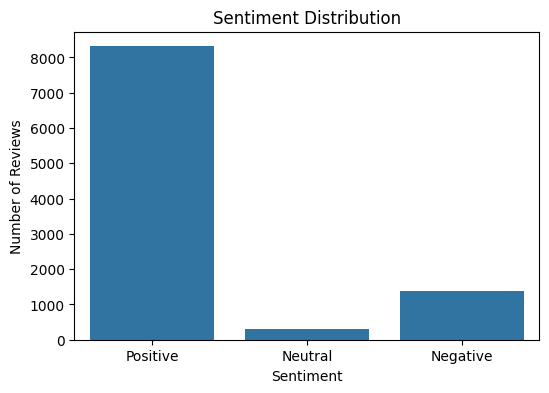

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

### **6. Keyword Analysis: Top 10 Terms**

In [ ]:
def extract_keywords(text_series, top_n=10):
    vec = CountVectorizer(max_features=top_n, stop_words='english')
    X = vec.fit_transform(text_series)
    freqs = X.sum(axis=0).A1
    keywords = vec.get_feature_names_out()
    return pd.DataFrame({'Keyword': keywords, 'Frequency': freqs}).sort_values(by='Frequency', ascending=False)

positive_text = df[df['sentiment']=='Positive']['clean_text']
negative_text = df[df['sentiment']=='Negative']['clean_text']

positive_keywords_df = extract_keywords(positive_text, top_n=10)
negative_keywords_df = extract_keywords(negative_text, top_n=10)

positive_keywords_df, negative_keywords_df

(     Keyword  Frequency
 7       room       7245
 5      hotel       6208
 8      staff       3725
 9       stay       3410
 4      great       3398
 1      clean       3140
 3       good       3089
 0  breakfast       2685
 6       nice       2672
 2   friendly       2021,
   Keyword  Frequency
 6    room       1366
 4   hotel        807
 0     bad        425
 3    good        366
 8    stay        327
 5   night        314
 7   staff        257
 2    desk        245
 1     bed        244
 9    time        212)

### **6.1 Word Cloud Visualization**

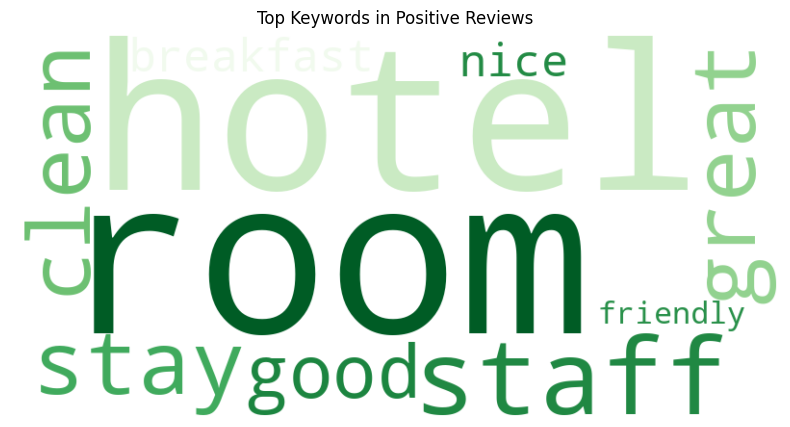

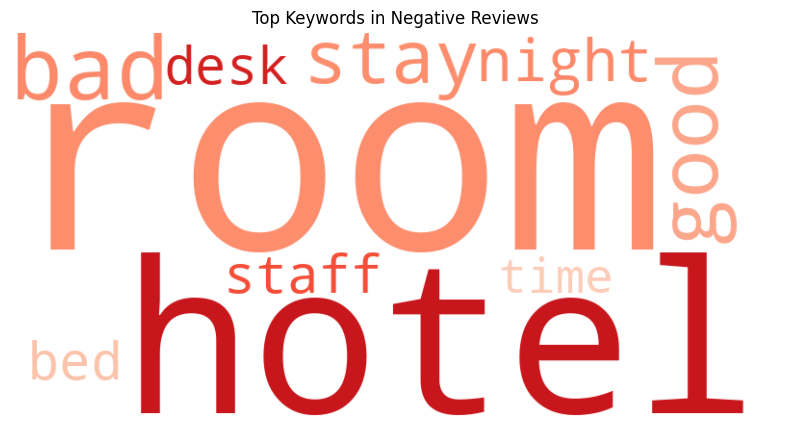

In [ ]:
def plot_wordcloud(keyword_df, title, colormap='Greens'):
    freqs = {row['Keyword']: row['Frequency'] for idx, row in keyword_df.iterrows()}
    wc = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(freqs)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(positive_keywords_df, "Top Keywords in Positive Reviews", colormap='Greens')
plot_wordcloud(negative_keywords_df, "Top Keywords in Negative Reviews", colormap='Reds')

### **7. ANN Model: Review Rating Prediction**

### **7.1 Convert Ratings to Classes**

In [ ]:
def rating_to_class(rating):
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['rating_class'] = df['reviews.rating'].apply(rating_to_class)
df['rating_class'].value_counts()

,count
rating_class,
2,7660
1,1186
0,1153


### **7.2 Train-Test Split**

In [ ]:
y = df['rating_class']

# BoW split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

### **7.3 Train ANN Model**

In [ ]:
def train_ann(X_train, y_train):
    ann = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',
                        solver='adam', max_iter=300, random_state=42)
    ann.fit(X_train, y_train)
    return ann

# Train BoW model
ann_bow = train_ann(X_train_bow, y_train)

# Train TF-IDF model
ann_tfidf = train_ann(X_train_tfidf, y_train_tfidf)

### **7.4 Model Evaluation: BoW vs TF-IDF**

              precision    recall  f1-score   support

    Negative       0.60      0.56      0.58       231
     Neutral       0.30      0.25      0.27       237
    Positive       0.88      0.91      0.89      1532

    accuracy                           0.79      2000
   macro avg       0.59      0.57      0.58      2000
weighted avg       0.78      0.79      0.78      2000



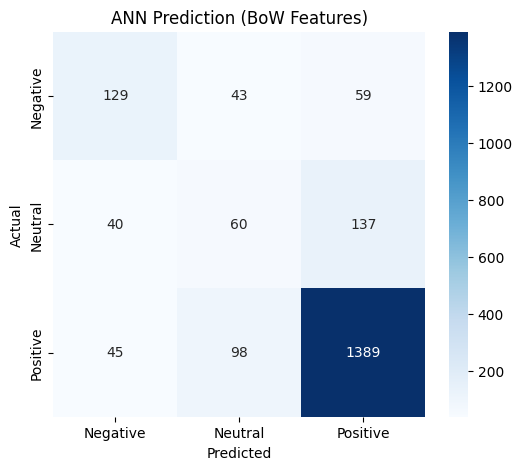

              precision    recall  f1-score   support

    Negative       0.59      0.51      0.55       231
     Neutral       0.29      0.27      0.28       237
    Positive       0.87      0.90      0.88      1532

    accuracy                           0.78      2000
   macro avg       0.58      0.56      0.57      2000
weighted avg       0.77      0.78      0.77      2000



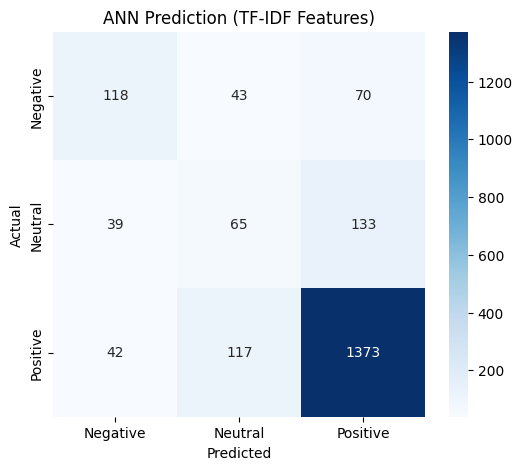

In [ ]:
def evaluate_model(model, X_test, y_test, title="Confusion Matrix"):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative','Neutral','Positive'],
                yticklabels=['Negative','Neutral','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# BoW Evaluation
evaluate_model(ann_bow, X_test_bow, y_test, title="ANN Prediction (BoW Features)")

# TF-IDF Evaluation
evaluate_model(ann_tfidf, X_test_tfidf, y_test_tfidf, title="ANN Prediction (TF-IDF Features)")


### **8. Interpretation of Results**

- VADER Sentiment: Provides descriptive overview of positive, neutral, and negative customer feedback.

- ANN BoW vs TF-IDF: Both approaches predict review ratings; TF-IDF may reduce influence of common words and slightly improve detection of neutral/negative reviews.

- Insights: Positive reviews dominate, negative reviews reveal key areas for service improvement. ANN models are useful for predictive analytics but limited by class imbalance and word representation.

### **9. Stakeholder Recommendations**

- Focus on rooms, beds, and check-in/out process.

- Use keyword analysis to prioritize maintenance, staff training, and noise management.

- Leverage ANN model to automatically flag potential negative reviews for follow-up.

### **10. Future Improvements**

- Address class imbalance via resampling or class weights.

- Try embeddings (Word2Vec, BERT) for richer text representation.

- Tune ANN hyperparameters or explore alternative classifiers (SVM, LSTM).

- Incorporate domain-specific sentiment lexicons.

### **11. Reproducibility Notes**

- Fixed random_state for splits and ANN training.

- All preprocessing steps are explicitly defined.

- Requires: pandas, numpy, nltk, scikit-learn, matplotlib, seaborn, wordcloud.

- NLTK resources are downloaded within the notebook.